# OxAria NO2 sensor baseline analysis


This analysis explores the application of statistical algorithms development in the analytical spectroscopy domain for handling & correction of baseline offsets within OxAria sensor data holdings & utilising reference method observations at (Oxford) city background & city roadside locations as a frame of reference.

Time series plots of 15-minute average NO2 concentrations (Fig1.) have shown that sensor baseline conditions exhibited by sensors across the OxAria sensor newtork were broadly stable during 2020, with some excepts. However, it is also noted from Fig1 that the offset in the sensor baseline signal varies from sensor to sensor. 
Variability in the sensor baseline offset presents a barrier to developing & applying a common regression model to correct for sensor interferences across the OxAria sensor data holdings. This in turnis an obstacle for data handling efficacy & transparency.

## Aim
* A simple, robust, replicable & recognised method for correction of sensor baseline offset
* Easily deployable across the OxAria network
* Facilating the deployment of regression models for correction of NO2 sensor interferences


In [1]:
# Imports
#---------
import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator
import matplotlib as mpl
import peakutils
from peakutils.plot import plot as pplot
import warnings
warnings.filterwarnings("ignore")

register_matplotlib_converters()

# File locations
#----------------
the_gases = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/1oxaria/json/gap_filling/'
pngs = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/pngs/gap_filling/'
the_folder = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/'


In [2]:
# Load stable 15-min sensor data as single df
#------------------------------------
pm = pd.read_feather(the_folder + 'oxaria_pm_536_stable15.ftr')

# Load AURN 15-min data as single df
#------------------------------------
auto_merged = pd.read_feather('/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/auto_merged_ratified.ftr')

# Quite possible the baselines will have already been calculated,
# so dropping these for recalc
try:
    auto_merged.drop(
        columns=['pm10_ugg_s_bl', 'pm10_ugg_h_bl', 'pm25_ugg_s_bl'],
        axis=1,
        inplace=True)
except Exception:
    pass

In [3]:
auto_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35136 entries, 0 to 35135
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   sitecode_s     35136 non-null  object             
 1   name_s         35136 non-null  object             
 2   rec            35136 non-null  datetime64[ns, UTC]
 3   no_ppb_s       34398 non-null  float32            
 4   no2_ppb_s      34398 non-null  float32            
 5   pm10_ugg_s     35120 non-null  float32            
 6   o3_ppb_s       35051 non-null  float32            
 7   pm25_ugg_s     35120 non-null  float32            
 8   fidas_t_s      35125 non-null  float32            
 9   fidas_rh_s     35125 non-null  float32            
 10  sitecode_h     35136 non-null  object             
 11  name_h         35136 non-null  object             
 12  no_ppb_h       34189 non-null  float32            
 13  no2_ppb_h      34189 non-null  float32        

## Typical sensor baseline characteristics
Fig1 presents typical sensor baseline characteristics for the Praxis Urban sensors deployed by OxAria.One can see with the exception of scs-bgx-536 at the High St location, sensor response is broadly consistent across the network. Note, however, the autoscaled y-axis disguises both the variable offset(s) & consistency in the signal noise across all sensors. This latter observation is illustrated by the comparing the mean standard deviation & coefficient of variation presented below.

In [4]:
# Calc mean, std dev & coeff of variation for each sensor
#---------------------------------------------------------
for tag, dat in pm.groupby('tag'):
    x = dat['val.pm10_1'].std()
    y = dat['val.pm10_1'].mean()
    p = x / y
    print(f'PM10 Mean, std. deviation & CV of {tag} is: {y:.0f},    {x:.1f},     {p:.1f}.')

# Calc mean, std dev & coeff of variation for each sensor
#---------------------------------------------------------
print('')
for tag, dat in pm.groupby('tag'):
    x = dat['val.pm2p5_1'].std()
    y = dat['val.pm2p5_1'].mean()
    p = x / y
    print(f'PM2.5 Mean, std. deviation & CV of {tag} is: {y:.0f},    {x:.1f},     {p:.1f}.')    

PM10 Mean, std. deviation & CV of scs-bgx-536 is: 55,    232.1,     4.2.
PM10 Mean, std. deviation & CV of scs-bgx-537 is: 90,    467.3,     5.2.
PM10 Mean, std. deviation & CV of scs-bgx-538 is: 57,    169.6,     3.0.
PM10 Mean, std. deviation & CV of scs-bgx-539 is: 28,    67.9,     2.5.
PM10 Mean, std. deviation & CV of scs-bgx-540 is: 46,    160.4,     3.5.
PM10 Mean, std. deviation & CV of scs-bgx-541 is: 30,    47.8,     1.6.
PM10 Mean, std. deviation & CV of scs-bgx-542 is: 32,    105.4,     3.3.
PM10 Mean, std. deviation & CV of scs-bgx-543 is: 99,    376.6,     3.8.
PM10 Mean, std. deviation & CV of scs-bgx-550 is: 223,    1195.9,     5.4.
PM10 Mean, std. deviation & CV of scs-bgx-551 is: 108,    532.7,     4.9.
PM10 Mean, std. deviation & CV of scs-bgx-552 is: 76,    447.8,     5.9.
PM10 Mean, std. deviation & CV of scs-bgx-553 is: 98,    499.0,     5.1.
PM10 Mean, std. deviation & CV of scs-bgx-554 is: 77,    370.1,     4.8.
PM10 Mean, std. deviation & CV of scs-bgx-556 is: 

In [5]:
# load airpls functions for St Ebbes baselining
# adaptive iteratively reweighted Penalized Least Squares algorithm function (airPLS)
# https://github.com/zmzhang/airPLS
#-------------------------------------------------------------------------------------

import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.linalg import cholesky
# from scikits.sparse.cholmod import cholesky
from scipy import sparse

from scipy.stats import norm
import matplotlib.pyplot as plt


def als(y, lam=1e6, p=0.1, itermax=10):
    r"""
    Implements an Asymmetric Least Squares Smoothing
    baseline correction algorithm (P. Eilers, H. Boelens 2005)

    Baseline Correction with Asymmetric Least Squares Smoothing
    based on https://github.com/vicngtor/BaySpecPlots

    Baseline Correction with Asymmetric Least Squares Smoothing
    Paul H. C. Eilers and Hans F.M. Boelens
    October 21, 2005

    Description from the original documentation:

    Most baseline problems in instrumental methods are characterized by a smooth
    baseline and a superimposed signal that carries the analytical information: a series
    of peaks that are either all positive or all negative. We combine a smoother
    with asymmetric weighting of deviations from the (smooth) trend get an effective
    baseline estimator. It is easy to use, fast and keeps the analytical peak signal intact.
    No prior information about peak shapes or baseline (polynomial) is needed
    by the method. The performance is illustrated by simulation and applications to
    real data.


    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        p:
            wheighting deviations. 0.5 = symmetric, <0.5: negative
            deviations are stronger suppressed
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    L = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    D = sparse.eye(L, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]
    D = D.T
    w = np.ones(L)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z


def arpls(y, lam=1e4, ratio=0.05, itermax=100):
    r"""
    Baseline correction using asymmetrically
    reweighted penalized least squares smoothing
    Sung-June Baek, Aaron Park, Young-Jin Ahna and Jaebum Choo,
    Analyst, 2015, 140, 250 (2015)

    Abstract

    Baseline correction methods based on penalized least squares are successfully
    applied to various spectral analyses. The methods change the weights iteratively
    by estimating a baseline. If a signal is below a previously fitted baseline,
    large weight is given. On the other hand, no weight or small weight is given
    when a signal is above a fitted baseline as it could be assumed to be a part
    of the peak. As noise is distributed above the baseline as well as below the
    baseline, however, it is desirable to give the same or similar weights in
    either case. For the purpose, we propose a new weighting scheme based on the
    generalized logistic function. The proposed method estimates the noise level
    iteratively and adjusts the weights correspondingly. According to the
    experimental results with simulated spectra and measured Raman spectra, the
    proposed method outperforms the existing methods for baseline correction and
    peak height estimation.

    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        ratio:
            wheighting deviations: 0 < ratio < 1, smaller values allow less negative values
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    N = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(N), 2))
    D = sparse.eye(N, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]

    H = lam * D.T * D
    w = np.ones(N)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(N, N))
        WH = sparse.csc_matrix(W + H)
        C = sparse.csc_matrix(cholesky(WH.todense()))
        z = spsolve(C, spsolve(C.T, w * y))
        d = y - z
        dn = d[d < 0]
        m = np.mean(dn)
        s = np.std(dn)
        wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
        if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
            break
        w = wt
    return z


def WhittakerSmooth(x, w, lam, differences=1):
    '''
    Penalized least squares algorithm for background fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        w:
            binary masks (value of the mask is zero if a point belongs to peaks
            and one otherwise)
        lam:
            parameter that can be adjusted by user. The larger lambda is,  the
            smoother the resulting background
        differences:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    X = np.matrix(x)
    m = X.size
#    D = csc_matrix(np.diff(np.eye(m), differences))
    D = sparse.eye(m, format='csc')
    for i in range(differences):
        D = D[1:] - D[:-1]  # numpy.diff() does not work with sparse matrix. This is a workaround.
    W = sparse.diags(w, 0, shape=(m, m))
    A = sparse.csc_matrix(W + (lam * D.T * D))
    B = sparse.csc_matrix(W * X.T)
    background = spsolve(A, B)
    return np.array(background)


def airpls(x, lam=100, porder=1, itermax=100):
    '''
    airpls.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
    Baseline correction using adaptive iteratively reweighted penalized least squares

    This program is a translation in python of the R source code of airPLS version 2.0
    by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls
    Reference:
    Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive
    iteratively reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

    Description from the original documentation:

    Baseline drift always blurs or even swamps signals and deteriorates analytical
    results, particularly in multivariate analysis.  It is necessary to correct
    baseline drift to perform further data analysis. Simple or modified polynomial
    fitting has been found to be effective in some extent. However, this method
    requires user intervention and prone to variability especially in low
    signal-to-noise ratio environments. The proposed adaptive iteratively
    reweighted Penalized Least Squares (airPLS) algorithm doesn't require any
    user intervention and prior information, such as detected peaks. It
    iteratively changes weights of sum squares errors (SSE) between the fitted
    baseline and original signals, and the weights of SSE are obtained adaptively
    using between previously fitted baseline and original signals. This baseline
    estimator is general, fast and flexible in fitting baseline.

    Adaptive iteratively reweighted penalized least squares for baseline fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        porder:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    m = x.shape[0]
    w = np.ones(m)
    for i in range(1, itermax + 1):
        z = WhittakerSmooth(x, w, lam, porder)
        d = x - z
        dssn = np.abs(d[d < 0].sum())
        if(dssn < 0.001 * (abs(x)).sum() or i == itermax):
            if(i == itermax):
                print('airpls: max iteration reached!')
            break
        w[d >= 0] = 0  # d>0 means that this point is part of a peak,
        # so its weight is set to 0 in order to ignore it
        w[d < 0] = np.exp(i * np.abs(d[d < 0]) / dssn)
        w[0] = np.exp(i * (d[d < 0]).max() / dssn)
        w[-1] = w[0]
    return z


In [6]:
# Calc St Ebbes & High St baselines using airPLS as 1st approximations - pm10
# -----------------------------------------------------------------------------

# drop rows with missing values
tmp0 = auto_merged.reset_index().dropna(
    subset=['rec', 'pm10_ugg_s', 'pm10_ugg_h'], axis=0)
# assign df cols to arrays
x0 = tmp0['rec'].values
ys = tmp0['pm10_ugg_s'].values
yh = tmp0['pm10_ugg_h'].values
# calc baseline using airpls function & default settings- st ebbes
try:
    ys_bl = airpls(ys, lam=400, porder=1, itermax=100)
except ValueError:  # raised if `y` is empty.
    pass

try:
    yh_bl = airpls(yh, lam=400, porder=1, itermax=100)
except ValueError:  # raised if `y` is empty.
    pass

# convert arrays to dfs
x0_df = pd.DataFrame(list(x0), columns=['rec'])
y_bl_df = pd.DataFrame(list(zip(ys_bl, yh_bl)),
                       columns=['pm10_ugg_s_bl', 'pm10_ugg_h_bl'])
# join cols together - rec, st ebbes baseline & high st baseline
tmp1 = pd.concat([x0_df, y_bl_df], axis=1)
# housekeeping
tmp1['rec'] = pd.to_datetime(tmp1['rec'],
                             utc=True)  # .set_index('rec',drop=True)
tmp1.set_index('rec', inplace=True, drop=True)
# join baseline info back on to source file
auto_merged = pd.merge(auto_merged,
                       tmp1,
                       how='left',
                       on='rec')
# housekeeping
#auto_merged.set_index('rec', inplace=True, drop=True)
#auto_merged[['pm10_ugg_s_bl', 'pm10_ugg_h_bl'
#             ]] = auto_merged[['pm10_ugg_s_bl',
#                               'pm10_ugg_h_bl']].astype(np.float32)

In [7]:
# Calc St Ebbes baselines using airPLS as 1st approximations - pm2.5
#--------------------------------------------------------------------

# drop rows with missing values
tmp0 = auto_merged.reset_index().dropna(subset=['rec', 'pm25_ugg_s'], axis=0)
# assign df cols to arrays
x0 = tmp0['rec'].values
ys = tmp0['pm25_ugg_s'].values
# calc baseline using airpls function & default settings- st ebbes
try:
    ys_bl = airpls(ys, lam=400, porder=1, itermax=100)
except ValueError:  #raised if `y` is empty.
    pass

# convert arrays to dfs
x0_df = pd.DataFrame(list(x0), columns=['rec'])
y_bl_df = pd.DataFrame(ys_bl, columns=['pm25_ugg_s_bl'])
# join cols together - rec, st ebbes baseline & high st baseline
tmp1 = pd.concat([x0_df, y_bl_df], axis=1)
# housekeeping
tmp1['rec'] = pd.to_datetime(tmp1['rec'],
                             utc=True)  #.set_index('rec',drop=True)
tmp1.set_index('rec', inplace=True, drop=True)
# join baseline info back on to source file
auto_merged = pd.merge(auto_merged, \
                       tmp1, \
                       how='left',\
                       on='rec')
# housekeeping
auto_merged.reset_index().set_index('rec', inplace=True, drop=True)
auto_merged[['pm25_ugg_s_bl']] = auto_merged[['pm25_ugg_s_bl'
                                              ]].astype(np.float32)


In [8]:
auto_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35136 entries, 0 to 35135
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   sitecode_s     35136 non-null  object             
 1   name_s         35136 non-null  object             
 2   rec            35136 non-null  datetime64[ns, UTC]
 3   no_ppb_s       34398 non-null  float32            
 4   no2_ppb_s      34398 non-null  float32            
 5   pm10_ugg_s     35120 non-null  float32            
 6   o3_ppb_s       35051 non-null  float32            
 7   pm25_ugg_s     35120 non-null  float32            
 8   fidas_t_s      35125 non-null  float32            
 9   fidas_rh_s     35125 non-null  float32            
 10  sitecode_h     35136 non-null  object             
 11  name_h         35136 non-null  object             
 12  no_ppb_h       34189 non-null  float32            
 13  no2_ppb_h      34189 non-null  float32        

In [9]:
# Calc pm10 & pm2.5 sensor baseline with airPLS
#-----------------------------------------------

# pm10
#------
# create temporary list
tmp_list = []
# calc baselines for each sensor group
for tag, df in pm.reset_index().groupby('tag'):
    # drop rows with missing data
    tmp0 = df.dropna(subset=['rec', 'val.pm10_1'], axis=0)
    # assign df cols to arrays
    tag0 = tmp0['tag'].values
    x0 = tmp0['rec'].values
    y0 = tmp0['val.pm10_1'].values
    # calc baseline using airpls function & default settings
    y0_bl = airpls(y0, lam=400, porder=1, itermax=100)
    # convert arrays to dfs
    x0_df = pd.DataFrame(list(zip(tag0, x0)), columns=['tag', 'rec'])
    y0_bl_df = pd.DataFrame(list(y0_bl), columns=['val.pm10_1_bl'])
    # join cols together - tag, rec & no2 baseline
    tmp1 = pd.concat([x0_df, y0_bl_df], axis=1)
    # housekeeping
    tmp1['rec'] = pd.to_datetime(tmp1['rec'], utc=True)
    # append to rmp_list for each iteration
    tmp_list.append(tmp1)
# combine the list of dfs into single df
tmp_df = pd.concat(tmp_list).set_index(['tag', 'rec'], drop=True)
# merge info back on to source df
pm = pd.merge(pm, tmp_df, how='left', on=['tag', 'rec'])

# pm2.5
#-------
# create temporary list
tmp_list = []
# calc baselines for each sensor group
for tag, df in pm.reset_index().groupby('tag'):
    # drop rows with missing data
    tmp0 = df.dropna(subset=['rec', 'val.pm2p5_1'], axis=0)
    # assign df cols to arrays
    tag0 = tmp0['tag'].values
    x0 = tmp0['rec'].values
    y0 = tmp0['val.pm2p5_1'].values
    # calc baseline using airpls function & default settings
    y0_bl = airpls(y0, lam=400, porder=1, itermax=100)
    # convert arrays to dfs
    x0_df = pd.DataFrame(list(zip(tag0, x0)), columns=['tag', 'rec'])
    y0_bl_df = pd.DataFrame(list(y0_bl), columns=['val.pm2p5_1_bl'])
    # join cols together - tag, rec & no2 baseline
    tmp1 = pd.concat([x0_df, y0_bl_df], axis=1)
    # housekeeping
    tmp1['rec'] = pd.to_datetime(tmp1['rec'], utc=True)
    # append to rmp_list for each iteration
    tmp_list.append(tmp1)
# combine the list of dfs into single df
tmp_df = pd.concat(tmp_list).set_index(['tag', 'rec'], drop=True)
# merge info back on to source df
pm = pd.merge(pm, tmp_df, how='left', on=['tag', 'rec'])
# housekeeping
#pm.set_index(['tag', 'rec'], inplace=True, drop=True)


In [10]:
auto_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35136 entries, 0 to 35135
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   sitecode_s     35136 non-null  object             
 1   name_s         35136 non-null  object             
 2   rec            35136 non-null  datetime64[ns, UTC]
 3   no_ppb_s       34398 non-null  float32            
 4   no2_ppb_s      34398 non-null  float32            
 5   pm10_ugg_s     35120 non-null  float32            
 6   o3_ppb_s       35051 non-null  float32            
 7   pm25_ugg_s     35120 non-null  float32            
 8   fidas_t_s      35125 non-null  float32            
 9   fidas_rh_s     35125 non-null  float32            
 10  sitecode_h     35136 non-null  object             
 11  name_h         35136 non-null  object             
 12  no_ppb_h       34189 non-null  float32            
 13  no2_ppb_h      34189 non-null  float32        

<Figure size 432x288 with 0 Axes>

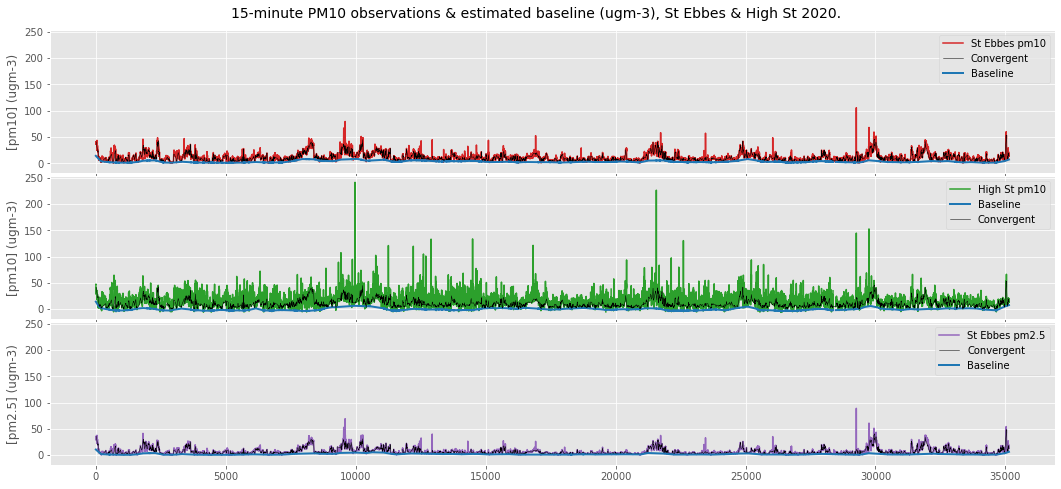

Average St Ebbes baseline = 3.185972047486777
Average High St baseline = -0.015303220580151827


In [11]:
# Plot St Ebbes timeseries baseline PM10
#----------------------------------------
plt.tight_layout()
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(18, 8), sharex=False, sharey=True)
plt.suptitle(
    '15-minute PM10 observations & estimated baseline (ugm-3), St Ebbes & High St 2020.',
    y=0.92,
    fontsize=14)
ax1.plot(auto_merged.index, auto_merged['pm10_ugg_s'], label='St Ebbes pm10',c='tab:red')
tmp = auto_merged.query('abs_pm10_diff <= 2.0')
ax1.plot(tmp.index, tmp['pm10_ugg_s'], lw=0.5, c='k', label='Convergent')
ax1.plot(auto_merged.index,
         auto_merged['pm10_ugg_s_bl'],
         lw=2,
         label='Baseline', c='tab:blue')
ax2.plot(auto_merged.index,
         auto_merged['pm10_ugg_h'],
         c='tab:green',
         label='High St pm10')
ax2.plot(auto_merged.index,
         auto_merged['pm10_ugg_h_bl'],
         lw=2,
         label='Baseline', c='tab:blue')
ax2.plot(tmp.index, tmp['pm10_ugg_s'], lw=0.5, c='k', label='Convergent')
ax3.plot(auto_merged.index, auto_merged['pm25_ugg_s'], label='St Ebbes pm2.5',c='tab:purple')
tmp = auto_merged.query('abs_pm10_diff <= 2.0')
ax3.plot(tmp.index, tmp['pm25_ugg_s'], lw=0.5, c='k', label='Convergent')
ax3.plot(auto_merged.index,
         auto_merged['pm25_ugg_s_bl'],
         lw=2,
         label='Baseline', c='tab:blue')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_ylabel('[pm10] (ugm-3)')
ax2.set_ylabel('[pm10] (ugm-3)')
ax3.set_ylabel('[pm2.5] (ugm-3)')


plt.subplots_adjust(hspace=0.02)
plt.show()

print('Average St Ebbes baseline = ' +
      str(auto_merged['pm10_ugg_s_bl'].mean()))
print('Average High St baseline = ' + str(auto_merged['pm10_ugg_h_bl'].mean()))

<Figure size 432x288 with 0 Axes>

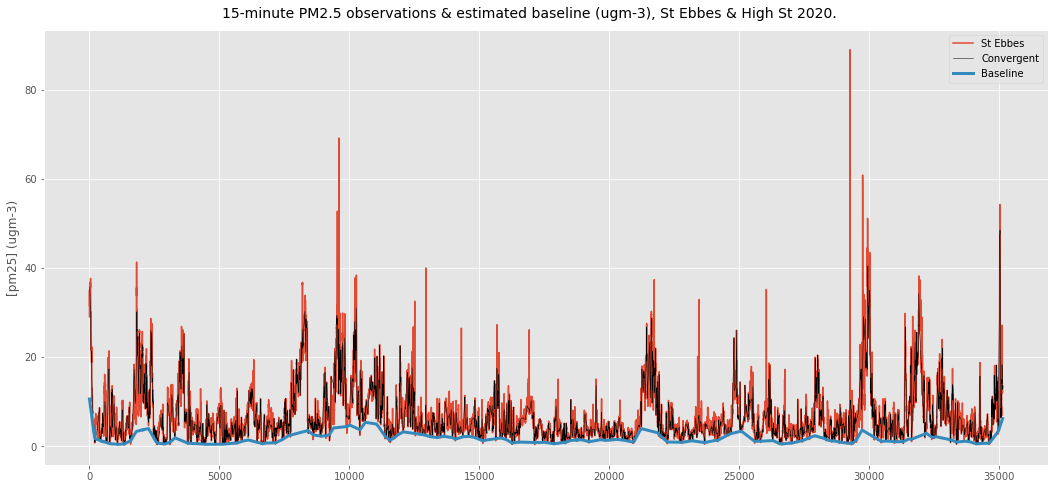

Average St Ebbes baseline = 1.7692409


In [12]:
# Plot St Ebbes timeseries baseline PM2.5
#----------------------------------------
plt.tight_layout()
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1, figsize=(18, 8), sharex=True, sharey=True)
plt.suptitle(
    '15-minute PM2.5 observations & estimated baseline (ugm-3), St Ebbes & High St 2020.',
    y=0.92,
    fontsize=14)
ax1.plot(auto_merged.index, auto_merged['pm25_ugg_s'], label='St Ebbes')
tmp = auto_merged.query('abs_pm10_diff <= 2.0')
ax1.plot(tmp.index, tmp['pm25_ugg_s'], lw=0.5, c='k', label='Convergent')
ax1.plot(auto_merged.index,
         auto_merged['pm25_ugg_s_bl'],
         lw=3,
         label='Baseline')
ax1.legend()
ax1.set_ylabel('[pm25] (ugm-3)')

plt.subplots_adjust(hspace=0.02)
plt.show()

print('Average St Ebbes baseline = ' +
      str(auto_merged['pm25_ugg_s_bl'].mean()))


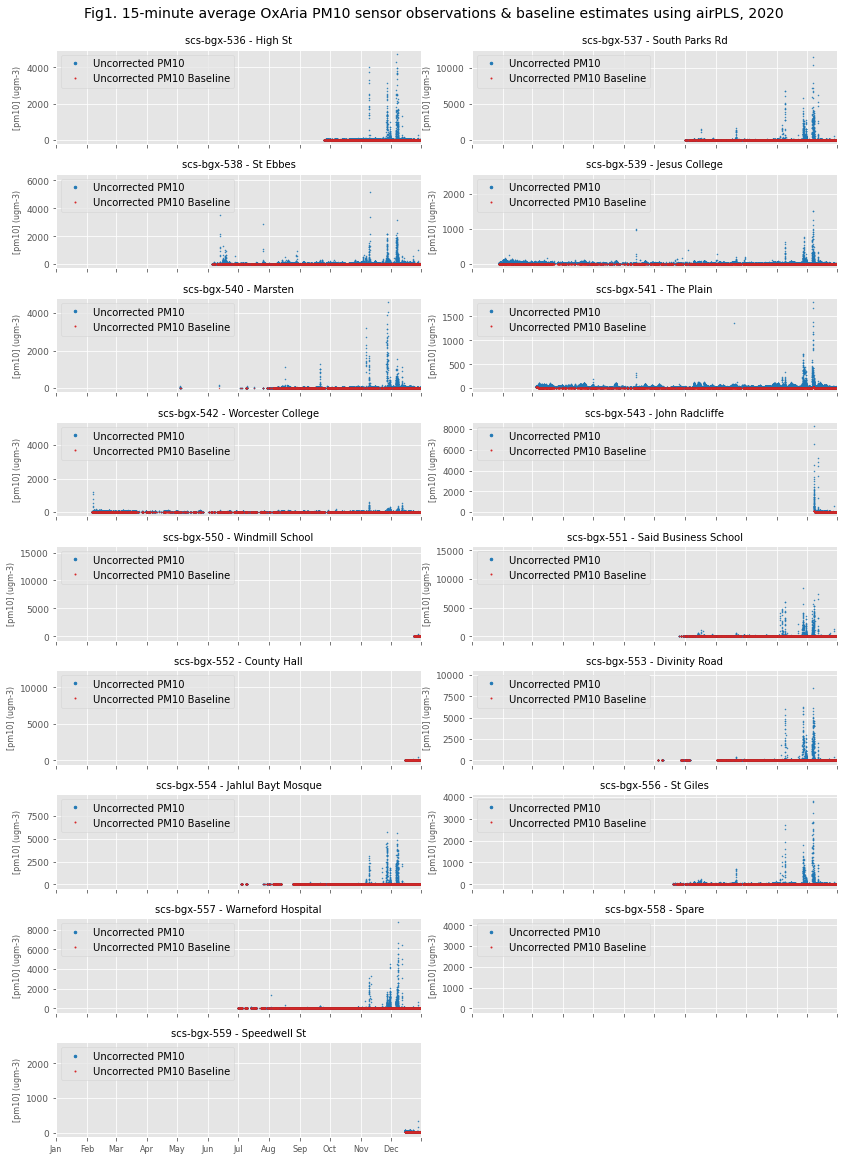

In [13]:
# Plot 15-minute snsor no2 & its baseline
#-----------------------------------------

plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date=dt.datetime(2020,1,1,0,0,0,0)
end_date=dt.datetime(2020,12,31,0,0,0,0)
labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
positions = [0,1,2,3,4,5,6,7,8,9,10,11,12]
locations = list(pd.date_range(start_date,end_date,freq='M',normalize=True))

fig, axes = plt.subplots(nrows=9, ncols=2, sharex=True, sharey=False, figsize=(14,20))
axes_list = [item for sublist in axes for item in sublist] 

fig.suptitle(
    'Fig1. 15-minute average OxAria PM10 sensor observations & baseline estimates using airPLS, 2020',
    fontsize=14,
    y=0.91)

for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    dat.plot(x='rec',y='val.pm10_1', c='tab:blue',linewidth=0.5, marker='o', ms=0.5, ls='', \
             label='Uncorrected PM10', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm10_1_bl', c='tab:red',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='Uncorrected PM10 Baseline', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag+' - '+t_name), fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=0,
        labelsize=8
        )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[pm10] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    ax.set_xticklabels(labels)
    #ax.xaxis.set_major_locator(ticker.FixedLocator(locs=locations))
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.subplots_adjust(wspace=0.14, hspace=0.31)
    ax.legend(markerscale=5, frameon=True, framealpha=0.75, loc='upper left')
fig.delaxes(axes_list.pop(-1))

plt.savefig(pngs+'oxaria0_no2_15m_raw_sensor_ts_ratified.png')
plt.show()    
    
for ax in axes_list:
    ax.remove()


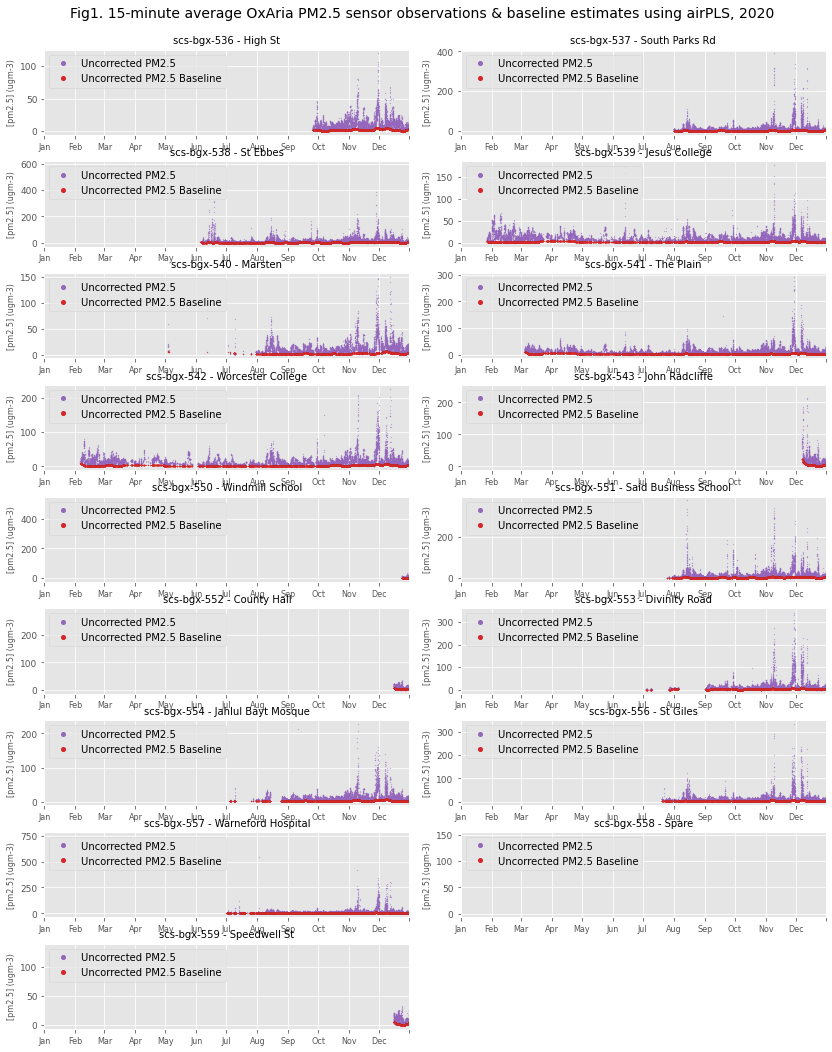

In [14]:
# Plot 15-minute snsor no2 & its baseline
#-----------------------------------------

plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date=dt.datetime(2020,1,1,0,0,0,0)
end_date=dt.datetime(2020,12,31,0,0,0,0)
labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
positions = [0,1,2,3,4,5,6,7,8,9,10,11,12]
locations = list(pd.date_range(start_date,end_date,freq='M',normalize=True))

fig, axes = plt.subplots(nrows=9, ncols=2, sharex=False, sharey=False, figsize=(14,20))
axes_list = [item for sublist in axes for item in sublist] 

fig.suptitle(
    'Fig1. 15-minute average OxAria PM2.5 sensor observations & baseline estimates using airPLS, 2020',
    fontsize=14,
    y=0.91)

for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    dat.plot(x='rec',y='val.pm2p5_1', c='tab:purple',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='Uncorrected PM2.5', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm2p5_1_bl', c='tab:red',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='Uncorrected PM2.5 Baseline', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag+' - '+t_name), fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=0,
        labelsize=8
        )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[pm2.5] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    ax.set_xticklabels(labels)
    #ax.xaxis.set_major_locator(ticker.FixedLocator(locs=locations))
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.subplots_adjust(wspace=0.14, hspace=0.31)
    ax.legend(markerscale=20, frameon=True, framealpha=0.75, loc='upper left')
fig.delaxes(axes_list.pop(-1))

plt.savefig(pngs+'oxaria0_no2_15m_raw_sensor_ts_ratified.png')
plt.show()    
    
for ax in axes_list:
    ax.remove()


In [15]:
# Adjust sensor PM output for baseline
#---------------------------------------
pm['val.pm10_1_c0'] = pm['val.pm10_1'] - pm['val.pm10_1_bl'] 
pm['val.pm2p5_1_c0'] = pm['val.pm2p5_1'] - pm['val.pm2p5_1_bl'] 


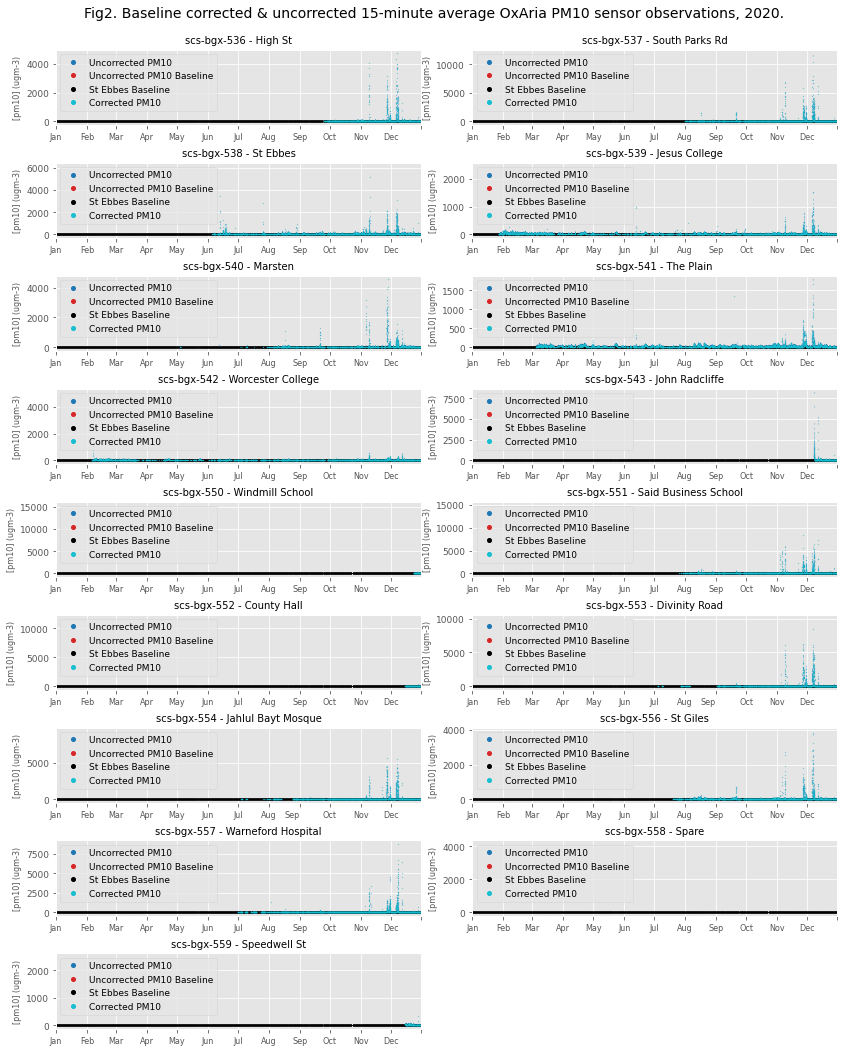

In [16]:
# Plot 15-minute sensor no2, baseline & baseline corrected sensor outputs
#-------------------------------------------------------------------------

plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date = dt.datetime(2020, 1, 1, 0, 0, 0, 0)
end_date = dt.datetime(2020, 12, 31, 0, 0, 0, 0)
labels = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
    'Nov', 'Dec'
]
positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
locations = list(pd.date_range(start_date, end_date, freq='M', normalize=True))

fig, axes = plt.subplots(nrows=9,
                         ncols=2,
                         sharex=False,
                         sharey=False,
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig2. Baseline corrected & uncorrected 15-minute average OxAria PM10 sensor observations, 2020.',
    fontsize=14,
    y=0.91)

for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    dat.plot(x='rec',y='val.pm10_1', c='tab:blue',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Uncorrected PM10', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm10_1_bl', c='tab:red',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Uncorrected PM10 Baseline', ax=ax, legend=True, zorder=1)
    auto_merged.plot(x='rec',y='pm10_ugg_s_bl', c='k',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='St Ebbes Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm10_1_c0', c='tab:cyan',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Corrected PM10', ax=ax, legend=True, zorder=1)
    #dat.plot(x='rec',y='val.no2.cnc_c0_bl', c='lime',linewidth=0.5, marker='o', ms=0.2, ls='', \
    #         label='Correction0_bl', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag + ' - ' + t_name), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[pm10] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    ax.set_xticklabels(labels)
    #ax.xaxis.set_major_locator(ticker.FixedLocator(locs=locations))
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.subplots_adjust(wspace=0.14, hspace=0.5)
    ax.legend(markerscale=40, frameon=True, framealpha=0.75, loc='upper left', fontsize=9)
fig.delaxes(axes_list.pop(-1))

plt.savefig(pngs+'oxaria0_no2_15m_raw_sensor_ts_ratified.png')
plt.show()

for ax in axes_list:
    ax.remove()

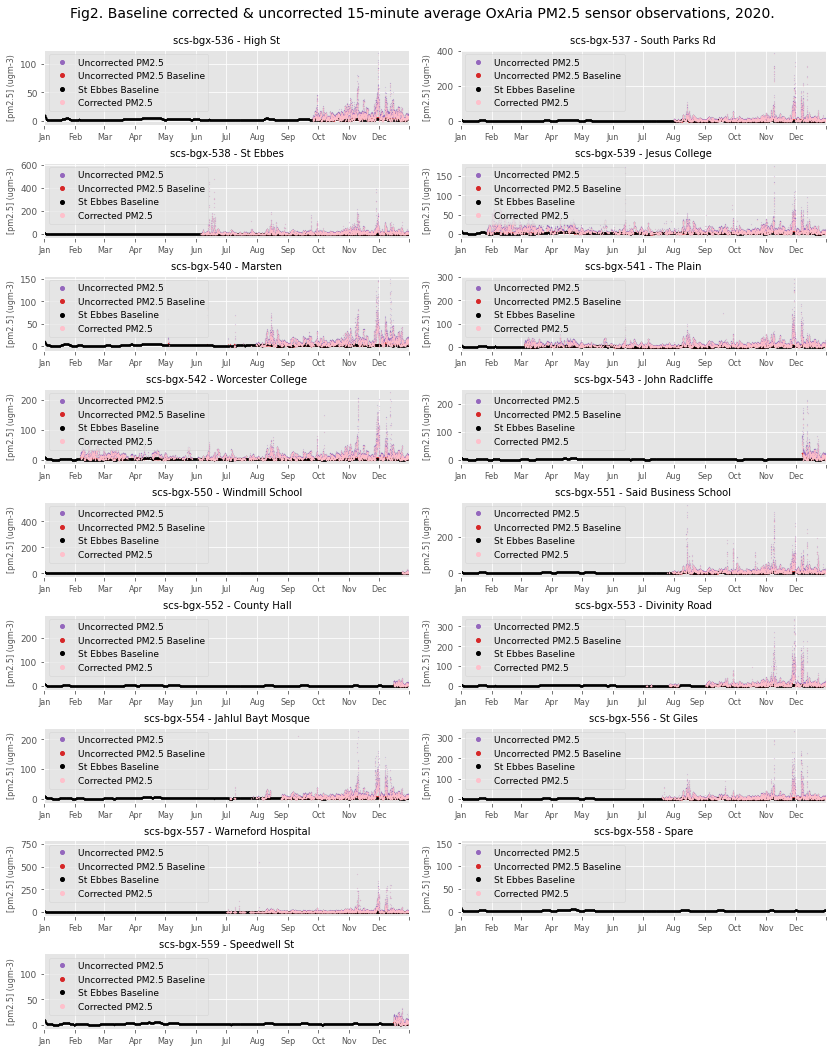

In [17]:
# Plot 15-minute sensor pm2.5, baseline & baseline corrected sensor outputs
#-------------------------------------------------------------------------

plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date = dt.datetime(2020, 1, 1, 0, 0, 0, 0)
end_date = dt.datetime(2020, 12, 31, 0, 0, 0, 0)
labels = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
    'Nov', 'Dec'
]
positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
locations = list(pd.date_range(start_date, end_date, freq='M', normalize=True))

fig, axes = plt.subplots(nrows=9,
                         ncols=2,
                         sharex=False,
                         sharey=False,
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig2. Baseline corrected & uncorrected 15-minute average OxAria PM2.5 sensor observations, 2020.',
    fontsize=14,
    y=0.91)

for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    dat.plot(x='rec',y='val.pm2p5_1', c='tab:purple',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Uncorrected PM2.5', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm2p5_1_bl', c='tab:red',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Uncorrected PM2.5 Baseline', ax=ax, legend=True, zorder=1)
    auto_merged.plot(x='rec',y='pm25_ugg_s_bl', c='k',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='St Ebbes Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm2p5_1_c0', c='pink',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Corrected PM2.5', ax=ax, legend=True, zorder=1)
    #dat.plot(x='rec',y='val.no2.cnc_c0_bl', c='lime',linewidth=0.5, marker='o', ms=0.2, ls='', \
    #         label='Correction0_bl', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag + ' - ' + t_name), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[pm2.5] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    ax.set_xticklabels(labels)
    #ax.xaxis.set_major_locator(ticker.FixedLocator(locs=locations))
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.subplots_adjust(wspace=0.14, hspace=0.5)
    ax.legend(markerscale=40, frameon=True, framealpha=0.75, loc='upper left', fontsize=9)
fig.delaxes(axes_list.pop(-1))

plt.savefig(pngs+'oxaria0_no2_15m_raw_sensor_ts_ratified.png')
plt.show()

for ax in axes_list:
    ax.remove()

In [18]:
pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341622 entries, 0 to 341621
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   tag             341622 non-null  object             
 1   rec             341622 non-null  datetime64[ns, UTC]
 2   val.mtf1        341622 non-null  float32            
 3   val.pm1         341622 non-null  float32            
 4   val.mtf5        341622 non-null  float32            
 5   val.pm2p5       341622 non-null  float32            
 6   val.mtf3        341622 non-null  float32            
 7   val.pm10        341622 non-null  float32            
 8   val.mtf7        341622 non-null  float32            
 9   val.per         341622 non-null  float32            
 10  val.sfr         341622 non-null  float32            
 11  val.sht.hmd     341622 non-null  float32            
 12  val.sht.tmp     341622 non-null  float32            
 13  val.pm10_1    

In [19]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 263122 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-03-01 00:00:00+0000', tz='UTC'))
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   val.pm2p5_1_bl  263122 non-null  float64
dtypes: float64(1)
memory usage: 4.2+ MB


In [20]:
# Calc baseline of the corrected pm2.5 sensor trace
#-------------------------------------------------
tmp_list = []

for tag, df in pm.reset_index().groupby('tag'):
    tmp0 = df.dropna(subset=['rec', 'val.pm10_1_c0'], axis=0)
    tag0 = tmp0['tag'].values
    x0 = tmp0['rec'].values
    y0 = tmp0['val.pm10_1_c0'].values
    y0_bl = airpls(
        y0, lam=400, porder=1, itermax=100
    )  # these default values seem to deliver good results, stay with
    x0_df = pd.DataFrame(list(zip(tag0,x0)), columns=['tag','rec'])
    y0_bl_df = pd.DataFrame(list(y0_bl), columns=['val.pm10_1_c0_bl'])
    tmp1 = pd.concat([x0_df, y0_bl_df], axis=1)
    tmp1['rec'] = pd.to_datetime(tmp1['rec'],
                                 utc=True)  # .set_index('rec',drop=True)
    tmp_list.append(tmp1)
tmp_df = pd.concat(tmp_list).set_index(['tag','rec'], drop=True)

pm = pd.merge(pm.set_index(['tag','rec']), tmp_df, how='left', left_index=True, right_index=True)
pm = pm.reset_index().merge(auto_merged.loc[:,['rec','pm10_ugg_s_bl']], how='left', on='rec')
pm['pm10bl_1_c0_offset'] = pm['pm10_ugg_s_bl'] - pm['val.pm10_1_c0_bl']
pm['val.pm10_1_c1'] = pm['val.pm10_1_c0'] + pm['pm10bl_1_c0_offset']
pm = pm.set_index(['tag','rec'])


In [21]:
# Calc baseline of the corrected pm2.5 sensor trace
#-------------------------------------------------
tmp_list = []

for tag, df in pm.reset_index().groupby('tag'):
    tmp0 = df.dropna(subset=['rec', 'val.pm2p5_1_c0'], axis=0)
    tag0 = tmp0['tag'].values
    x0 = tmp0['rec'].values
    y0 = tmp0['val.pm2p5_1_c0'].values
    y0_bl = airpls(
        y0, lam=400, porder=1, itermax=100
    )  # these default values seem to deliver good results, stay with
    x0_df = pd.DataFrame(list(zip(tag0,x0)), columns=['tag','rec'])
    y0_bl_df = pd.DataFrame(list(y0_bl), columns=['val.pm2p5_1_c0_bl'])
    tmp1 = pd.concat([x0_df, y0_bl_df], axis=1)
    tmp1['rec'] = pd.to_datetime(tmp1['rec'],
                                 utc=True)  # .set_index('rec',drop=True)
    tmp_list.append(tmp1)
       
tmp_df = pd.concat(tmp_list).set_index(['tag','rec'], drop=True) 
pm = pd.merge(pm, tmp_df, how='left', left_index=True, right_index=True)
pm = pm.reset_index().merge(auto_merged.loc[:,['rec','pm25_ugg_s_bl']], how='left', on='rec')
pm['pm25bl_1_c0_offset'] = pm['pm25_ugg_s_bl'] - pm['val.pm2p5_1_c0_bl']
pm['val.pm2p5_1_c1'] = pm['val.pm2p5_1_c0'] + pm['pm25bl_1_c0_offset']
pm = pm.set_index(['tag','rec'])


In [22]:
pm.loc[:,['pm10bl_1_c0_offset','pm25bl_1_c0_offset']].describe()

,pm10bl_1_c0_offset,pm25bl_1_c0_offset
count,175605.000000,179322.000000
mean,2.525994,1.435465
std,1.730610,0.794412
min,-89.575466,-6.411900
25%,1.736056,0.899400
50%,2.281017,1.202514
75%,3.289168,1.819623
max,8.781678,6.099557


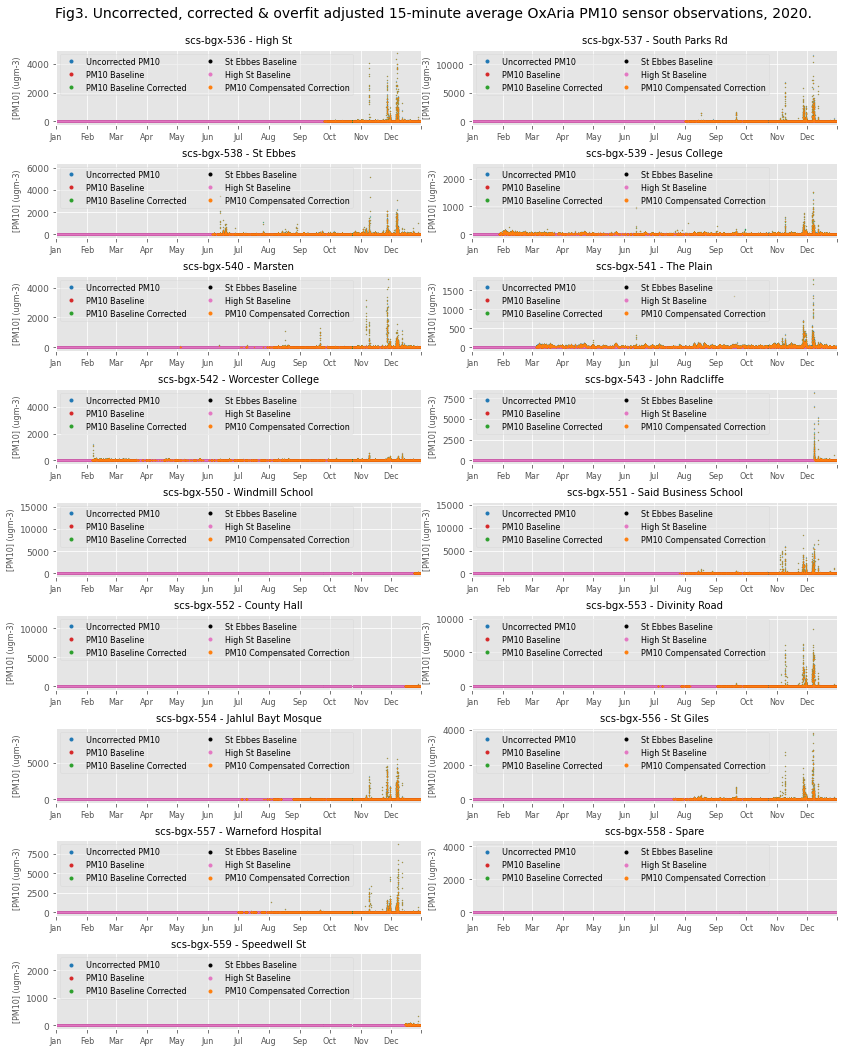

In [23]:
# Plot 15-minute sensor no2, baseline & baseline corrected sensor outputs
#-------------------------------------------------------------------------

plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date = dt.datetime(2020, 1, 1, 0, 0, 0, 0)
end_date = dt.datetime(2020, 12, 31, 0, 0, 0, 0)
labels = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
    'Nov', 'Dec'
]
positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
locations = list(pd.date_range(start_date, end_date, freq='M', normalize=True))

fig, axes = plt.subplots(nrows=9,
                         ncols=2,
                         sharex=False,
                         sharey=False,
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig3. Uncorrected, corrected & overfit adjusted 15-minute average OxAria PM10 sensor observations, 2020.',
    fontsize=14,
    y=0.91)
for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    dat.plot(x='rec',y='val.pm10_1', c='tab:blue',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='Uncorrected PM10', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm10_1_bl', c='tab:red',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='PM10 Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm10_1_c0', c='tab:green',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='PM10 Baseline Corrected', ax=ax, legend=True, zorder=1)
    auto_merged.plot(x='rec',y='pm10_ugg_s_bl', c='k',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='St Ebbes Baseline', ax=ax, legend=True, zorder=1)
    auto_merged.plot(x='rec',y='pm10_ugg_h_bl', c='tab:pink',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='High St Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm10_1_c1', c='tab:orange',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='PM10 Compensated Correction', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag + ' - ' + t_name), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[PM10] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    ax.set_xticklabels(labels)
    #ax.xaxis.set_major_locator(ticker.FixedLocator(locs=locations))
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.subplots_adjust(wspace=0.14, hspace=0.5)
    ax.legend(markerscale=15, frameon=True, framealpha=0.5, loc='upper left', ncol=2, fontsize = 8)
fig.delaxes(axes_list.pop(-1))

plt.savefig(pngs+'oxaria0_pm10_15m_raw_sensor_ts_ratified.png')
plt.show()

for ax in axes_list:
    ax.remove()

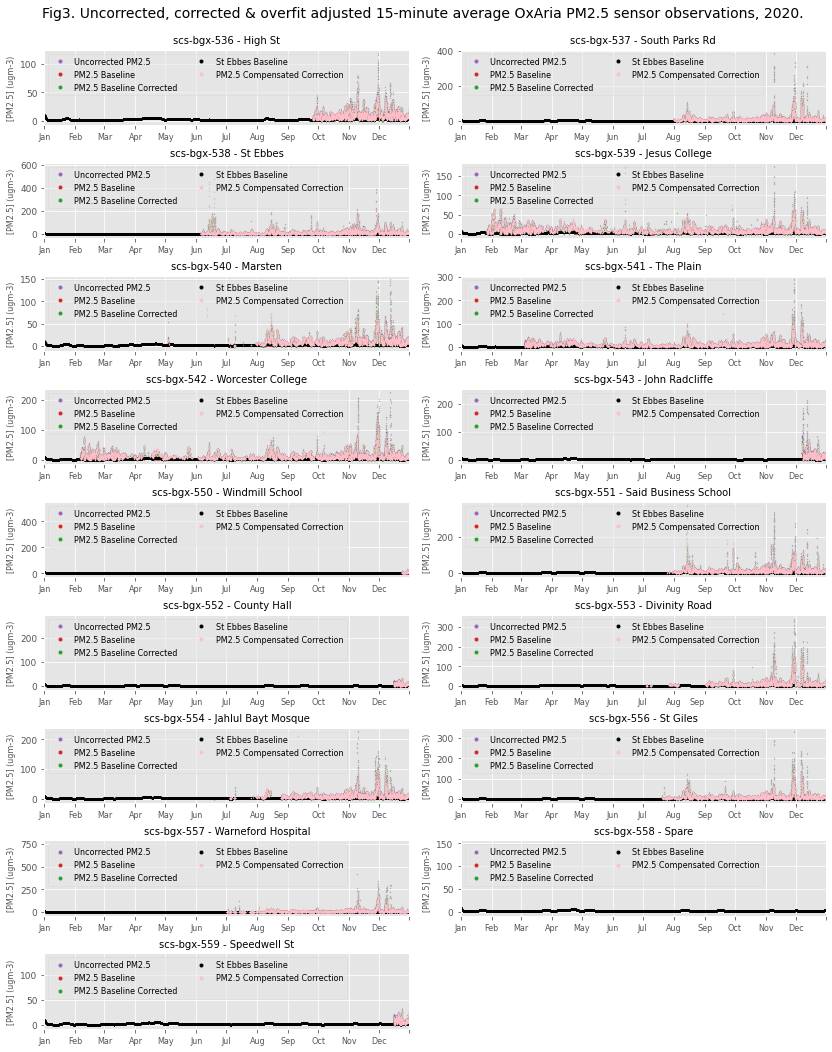

In [24]:
# Plot 15-minute sensor no2, baseline & baseline corrected sensor outputs
#-------------------------------------------------------------------------

plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date = dt.datetime(2020, 1, 1, 0, 0, 0, 0)
end_date = dt.datetime(2020, 12, 31, 0, 0, 0, 0)
labels = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
    'Nov', 'Dec'
]
positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
locations = list(pd.date_range(start_date, end_date, freq='M', normalize=True))

fig, axes = plt.subplots(nrows=9,
                         ncols=2,
                         sharex=False,
                         sharey=False,
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig3. Uncorrected, corrected & overfit adjusted 15-minute average OxAria PM2.5 sensor observations, 2020.',
    fontsize=14,
    y=0.91)
for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    dat.plot(x='rec',y='val.pm2p5_1', c='tab:purple',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='Uncorrected PM2.5', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm2p5_1_bl', c='tab:red',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='PM2.5 Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm2p5_1_c0', c='tab:green',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='PM2.5 Baseline Corrected', ax=ax, legend=True, zorder=1)
    auto_merged.plot(x='rec',y='pm25_ugg_s_bl', c='k',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='St Ebbes Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm2p5_1_c1', c='pink',linewidth=0.5, marker='o', ms=0.2, ls='', \
         label='PM2.5 Compensated Correction', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag + ' - ' + t_name), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[PM2.5] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    ax.set_xticklabels(labels)
    #ax.xaxis.set_major_locator(ticker.FixedLocator(locs=locations))
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.subplots_adjust(wspace=0.14, hspace=0.5)
    ax.legend(markerscale=15, frameon=True, framealpha=0.5, loc='upper left', ncol=2, fontsize = 8)
fig.delaxes(axes_list.pop(-1))

plt.savefig(pngs+'oxaria0_pm25_15m_raw_sensor_ts_ratified.png')
plt.show()

for ax in axes_list:
    ax.remove()

In [25]:
# Write to feather file
#-----------------------
pm.reset_index().to_feather(the_folder+'oxaria_pm_stable15_536_bl_adjusted.ftr')


In [26]:
# Join the baseline analysis data on to the feature dataset
#-----------------------------------------------------------
# load the datasets
pm = pd.read_feather(the_folder+'oxaria_pm_stable15_536_bl_adjusted.ftr')
pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341622 entries, 0 to 341621
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   tag                 341622 non-null  object             
 1   rec                 341622 non-null  datetime64[ns, UTC]
 2   val.mtf1            341622 non-null  float32            
 3   val.pm1             341622 non-null  float32            
 4   val.mtf5            341622 non-null  float32            
 5   val.pm2p5           341622 non-null  float32            
 6   val.mtf3            341622 non-null  float32            
 7   val.pm10            341622 non-null  float32            
 8   val.mtf7            341622 non-null  float32            
 9   val.per             341622 non-null  float32            
 10  val.sfr             341622 non-null  float32            
 11  val.sht.hmd         341622 non-null  float32            
 12  val.sht.tmp     

In [27]:
# Get number of corrected values below zero, then remove them
#--------------------------------------------------------------
df = pm.loc[:,['name','val.pm10_1_c1']]

print("Total no. of baseline corrected observations =  " +
      str(df['val.pm10_1_c1'].count()))
print("Total no. of bl corrected obs. below zero =  " +
      str(df['val.pm10_1_c1'].lt(0).sum()))
print("Total no. of bl corrected obs. below zero as % of total =  " +
      str(df['val.pm10_1_c1'].lt(0).sum() /
          df['val.pm10_1_c1'].count() * 100))

df['no_zeros'] = np.where(df['val.pm10_1_c1'].lt(0),np.nan,df['val.pm10_1_c1'])

print("\nAfter replacing zeros wth np.nans... \nTotal no. of baseline corrected observations =  " +
      str(df['no_zeros'].count()))
print("Total no. of bl corrected obs. below zero =  " +
      str(df['no_zeros'].lt(0).sum()))
print("Total no. of bl corrected obs. below zero as % of total =  " +
      str(df['no_zeros'].lt(0).sum() /
          df['no_zeros'].count() * 100))

Total no. of baseline corrected observations =  175605
Total no. of bl corrected obs. below zero =  427
Total no. of bl corrected obs. below zero as % of total =  0.24315936334386837

After replacing zeros wth np.nans... 
Total no. of baseline corrected observations =  175178
Total no. of bl corrected obs. below zero =  0
Total no. of bl corrected obs. below zero as % of total =  0.0


In [28]:
# Get number of corrected values below zero, then remove them
#--------------------------------------------------------------
df = pm.loc[:,['name','val.pm2p5_1_c1']]

print("Total no. of baseline corrected observations =  " +
      str(df['val.pm2p5_1_c1'].count()))
print("Total no. of bl corrected obs. below zero =  " +
      str(df['val.pm2p5_1_c1'].lt(0).sum()))
print("Total no. of bl corrected obs. below zero as % of total =  " +
      str(df['val.pm2p5_1_c1'].lt(0).sum() /
          df['val.pm2p5_1_c1'].count() * 100))

df['no_zeros'] = np.where(df['val.pm2p5_1_c1'].lt(0),np.nan,df['val.pm2p5_1_c1'])

print("\nAfter replacing zeros wth np.nans... \nTotal no. of baseline corrected observations =  " +
      str(df['no_zeros'].count()))
print("Total no. of bl corrected obs. below zero =  " +
      str(df['no_zeros'].lt(0).sum()))
print("Total no. of bl corrected obs. below zero as % of total =  " +
      str(df['no_zeros'].lt(0).sum() /
          df['no_zeros'].count() * 100))


Total no. of baseline corrected observations =  179322
Total no. of bl corrected obs. below zero =  68
Total no. of bl corrected obs. below zero as % of total =  0.03792061208329151

After replacing zeros wth np.nans... 
Total no. of baseline corrected observations =  179254
Total no. of bl corrected obs. below zero =  0
Total no. of bl corrected obs. below zero as % of total =  0.0


In [29]:
# Replace sub zeros with np.nans & overwrite with final correction
#------------------------------------------------------------------
pm['val.pm10_1_c1'] = np.where(pm['val.pm10_1_c1'].lt(0),np.nan,pm['val.pm10_1_c1'])
pm['val.pm2p5_1_c1'] = np.where(pm['val.pm2p5_1_c1'].lt(0),np.nan,pm['val.pm2p5_1_c1'])
pm.to_feather(the_folder+'oxaria_pm_stable15_536_bl_adjusted.ftr')


In [30]:
# Select St Ebbes only & baseline / correction columns generated above
#----------------------------------------------------------------------
sebbes_sensor_bl_info = pm.query('tag == "scs-bgx-538"').loc[:, [
    'tag', 'rec', 'val.pm10_1_bl', 'val.pm10_1_c0', 'val.pm10_1_c1',
    'val.pm10_1_c0_bl', 'pm10_ugg_s_bl',
    'val.pm2p5_1_bl', 'val.pm2p5_1_c0', 'val.pm2p5_1_c1',
    'val.pm2p5_1_c0_bl', 'pm25_ugg_s_bl'
]]
sebbes_sensor_bl_info.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25824 entries, 35424 to 61247
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   tag                25824 non-null  object             
 1   rec                25824 non-null  datetime64[ns, UTC]
 2   val.pm10_1_bl      21775 non-null  float64            
 3   val.pm10_1_c0      21775 non-null  float64            
 4   val.pm10_1_c1      16397 non-null  float64            
 5   val.pm10_1_c0_bl   21775 non-null  float64            
 6   pm10_ugg_s_bl      19777 non-null  float64            
 7   val.pm2p5_1_bl     21775 non-null  float64            
 8   val.pm2p5_1_c0     21775 non-null  float64            
 9   val.pm2p5_1_c1     16760 non-null  float64            
 10  val.pm2p5_1_c0_bl  21775 non-null  float64            
 11  pm25_ugg_s_bl      20151 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(1), flo

In [31]:
# Select St Ebbes only & baseline / correction columns generated above
#----------------------------------------------------------------------
highs_sensor_bl_info = pm.query('tag == "scs-bgx-536"').loc[:, [
    'tag', 'rec', 'val.pm10_1_bl', 'val.pm10_1_c0', 'val.pm10_1_c1',
    'val.pm10_1_c0_bl', 'pm10_ugg_s_bl',
    'val.pm2p5_1_bl', 'val.pm2p5_1_c0', 'val.pm2p5_1_c1',
    'val.pm2p5_1_c0_bl', 'pm25_ugg_s_bl'
]]
highs_sensor_bl_info.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15072 entries, 0 to 15071
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   tag                15072 non-null  object             
 1   rec                15072 non-null  datetime64[ns, UTC]
 2   val.pm10_1_bl      14311 non-null  float64            
 3   val.pm10_1_c0      14311 non-null  float64            
 4   val.pm10_1_c1      8905 non-null   float64            
 5   val.pm10_1_c0_bl   14311 non-null  float64            
 6   pm10_ugg_s_bl      9201 non-null   float64            
 7   val.pm2p5_1_bl     14311 non-null  float64            
 8   val.pm2p5_1_c0     14311 non-null  float64            
 9   val.pm2p5_1_c1     9129 non-null   float64            
 10  val.pm2p5_1_c0_bl  14311 non-null  float64            
 11  pm25_ugg_s_bl      9408 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(1), float64

In [32]:
# Load the training info we identified in step (7)
#-------------------------------------------------
sebbes_train_s15 = pd.read_feather(the_folder + 'sebbes_train_536_s15_ratified.ftr')
sebbes_train_s15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   tag                20160 non-null  object             
 1   rec                20160 non-null  datetime64[ns, UTC]
 2   val.no2.wev        20160 non-null  float32            
 3   val.no2.cnc        20160 non-null  float32            
 4   val.no2.aev        20160 non-null  float32            
 5   val.no2.wec        20160 non-null  float32            
 6   val.sht.hmd_g      20160 non-null  float32            
 7   val.sht.tmp_g      20160 non-null  float32            
 8   val.no2.cnc_1      19949 non-null  float32            
 9   name               20160 non-null  object             
 10  val.hmd            20160 non-null  float32            
 11  val.tmp            20160 non-null  float32            
 12  val.mtf1           20160 non-null  float32    

In [33]:
# Load the training info we identified in step (7)
#-------------------------------------------------
highs_train_s15 = pd.read_feather(the_folder + 'highs_train_536_s15_ratified.ftr')
highs_train_s15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   tag                9408 non-null   object             
 1   rec                9408 non-null   datetime64[ns, UTC]
 2   val.no2.wev        9408 non-null   float32            
 3   val.no2.cnc        9408 non-null   float32            
 4   val.no2.aev        9408 non-null   float32            
 5   val.no2.wec        9408 non-null   float32            
 6   val.sht.hmd_g      9408 non-null   float32            
 7   val.sht.tmp_g      9408 non-null   float32            
 8   val.no2.cnc_1      9408 non-null   float32            
 9   name               9408 non-null   object             
 10  val.hmd            9408 non-null   float32            
 11  val.tmp            9408 non-null   float32            
 12  val.mtf1           9408 non-null   float32      

In [34]:
# Join baseline / correction on by tag & rec
#--------------------------------------------
df3 = sebbes_train_s15.merge(sebbes_sensor_bl_info,
    on=['tag', 'rec'],
    how='left')
df3.info()

# Save to feather for reuse in RF modelling
#-------------------------------------------
df3.to_feather(the_folder+'sebbes_train_536_s15_ratified.ftr')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20160 entries, 0 to 20159
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   tag                20160 non-null  object             
 1   rec                20160 non-null  datetime64[ns, UTC]
 2   val.no2.wev        20160 non-null  float32            
 3   val.no2.cnc        20160 non-null  float32            
 4   val.no2.aev        20160 non-null  float32            
 5   val.no2.wec        20160 non-null  float32            
 6   val.sht.hmd_g      20160 non-null  float32            
 7   val.sht.tmp_g      20160 non-null  float32            
 8   val.no2.cnc_1      19949 non-null  float32            
 9   name               20160 non-null  object             
 10  val.hmd            20160 non-null  float32            
 11  val.tmp            20160 non-null  float32            
 12  val.mtf1           20160 non-null  float32    

In [35]:
# Join baseline / correction on by tag & rec
#--------------------------------------------
df3 = highs_train_s15.merge(highs_sensor_bl_info,
    on=['tag', 'rec'],
    how='left')
df3.info()

# Save to feather for reuse in RF modelling
#-------------------------------------------
df3.to_feather(the_folder+'highs_train_536_s15_ratified.ftr')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9408 entries, 0 to 9407
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   tag                9408 non-null   object             
 1   rec                9408 non-null   datetime64[ns, UTC]
 2   val.no2.wev        9408 non-null   float32            
 3   val.no2.cnc        9408 non-null   float32            
 4   val.no2.aev        9408 non-null   float32            
 5   val.no2.wec        9408 non-null   float32            
 6   val.sht.hmd_g      9408 non-null   float32            
 7   val.sht.tmp_g      9408 non-null   float32            
 8   val.no2.cnc_1      9408 non-null   float32            
 9   name               9408 non-null   object             
 10  val.hmd            9408 non-null   float32            
 11  val.tmp            9408 non-null   float32            
 12  val.mtf1           9408 non-null   float32      